# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">2. Model Training - LA Crime Forecasting</p>

### Overview

This notebook implements the two-stage crime forecasting model:
- **Stage 1**: Predict total crime count using regression (RandomForest vs XGBoost comparison)
- **Stage 2**: Distribute predicted total across crime types using historical proportions

We follow the ML workflow: Data Preprocessing -> Feature Engineering -> Baseline -> Model Training -> Evaluation

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Load Required Libraries</p>

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For saving models
import pickle

# Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("Libraries loaded successfully")

Libraries loaded successfully


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 4: Data Preparation</p>

### Load the Dataset

In [2]:
df_raw = pd.read_csv('../data/Crime_Data_from_2020_to_Present.csv')
print(f"Raw dataset shape: {df_raw.shape}")

# Keep essential columns
essential_cols = ['DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Crm Cd Desc']
df = df_raw[essential_cols].copy()

# Drop rows with missing essential values
df = df.dropna(subset=['DATE OCC', 'AREA', 'Crm Cd Desc'])
print(f"After dropping missing: {df.shape}")

Raw dataset shape: (1004991, 28)
After dropping missing: (1004991, 5)


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Time Imputation - Fixing Placeholder Values</p>

### Why Time Imputation?

As identified in EDA, many records have TIME OCC = 1200 (12:00 PM) as a placeholder. This creates an artificial spike that distorts temporal patterns. We redistribute these placeholder times to match the natural hourly distribution while tracking which records were imputed.

In [3]:
# Extract hour from TIME OCC
df['hour'] = df['TIME OCC'].fillna(1200).astype(int) // 100
df['hour'] = df['hour'].clip(0, 23)  # Ensure valid hours

# Identify placeholder records (hour 12 with exact 1200)
df['is_placeholder'] = (df['TIME OCC'] == 1200).astype(int)

# Count before imputation
hour_12_count = df['is_placeholder'].sum()
print(f"Records with TIME OCC = 1200: {hour_12_count:,}")
print(f"Percentage of total: {hour_12_count/len(df)*100:.1f}%")

Records with TIME OCC = 1200: 35,200
Percentage of total: 3.5%


In [4]:
# Calculate natural hourly distribution (excluding hour 12)
non_placeholder = df[df['is_placeholder'] == 0]
hourly_dist = non_placeholder['hour'].value_counts(normalize=True).sort_index()

# Remove hour 12 from distribution for redistribution
hourly_dist_no_12 = hourly_dist.drop(12, errors='ignore')
hourly_dist_no_12 = hourly_dist_no_12 / hourly_dist_no_12.sum()  # Renormalize

# Calculate expected hour 12 count based on interpolation
expected_hour_12 = (hourly_dist.get(11, 0) + hourly_dist.get(13, 0)) / 2 * len(df)
excess_hour_12 = hour_12_count - int(expected_hour_12)

print(f"Expected hour 12 count (interpolated): {expected_hour_12:,.0f}")
print(f"Excess records to redistribute: {excess_hour_12:,}")

Expected hour 12 count (interpolated): 46,246
Excess records to redistribute: -11,046


In [5]:
# Redistribute excess hour 12 records
np.random.seed(42)

# Track imputation
df['is_time_imputed'] = 0

# Get indices of placeholder records
placeholder_idx = df[df['is_placeholder'] == 1].index.tolist()

# Randomly select which ones to redistribute
if excess_hour_12 > 0:
    redistribute_idx = np.random.choice(placeholder_idx, size=min(excess_hour_12, len(placeholder_idx)), replace=False)
    
    # Assign new hours based on natural distribution
    new_hours = np.random.choice(
        hourly_dist_no_12.index, 
        size=len(redistribute_idx), 
        p=hourly_dist_no_12.values
    )
    
    df.loc[redistribute_idx, 'hour'] = new_hours
    df.loc[redistribute_idx, 'is_time_imputed'] = 1

print(f"Records with imputed time: {df['is_time_imputed'].sum():,}")

Records with imputed time: 0


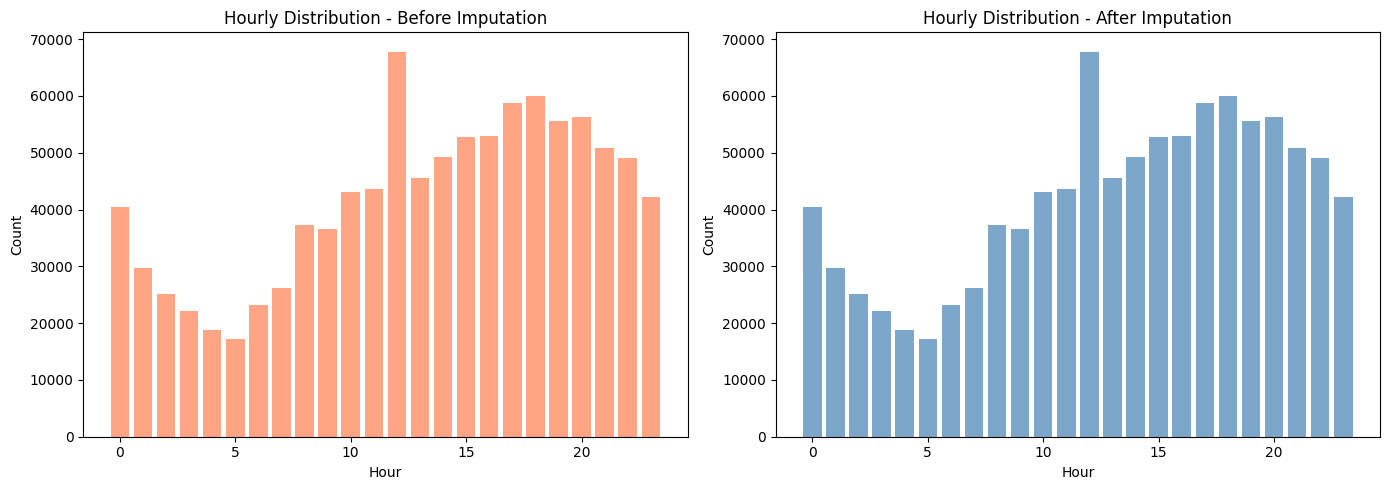

In [6]:
# Visualise before vs after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
before_counts = df_raw['TIME OCC'].fillna(1200).astype(int) // 100
before_counts = before_counts.clip(0, 23).value_counts().sort_index()
axes[0].bar(before_counts.index, before_counts.values, color='coral', alpha=0.7)
axes[0].set_title('Hourly Distribution - Before Imputation')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Count')

# After
after_counts = df['hour'].value_counts().sort_index()
axes[1].bar(after_counts.index, after_counts.values, color='steelblue', alpha=0.7)
axes[1].set_title('Hourly Distribution - After Imputation')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Time imputation successfully smoothed the distribution

The artificial spike at hour 12 has been reduced, creating a more realistic hourly crime curve. Records with imputed times are tracked via the `is_time_imputed` flag.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Feature Extraction</p>

In [7]:
# Parse date
df['date_occ'] = pd.to_datetime(df['DATE OCC'], format='mixed', errors='coerce')

# Extract temporal features
df['year'] = df['date_occ'].dt.year
df['month'] = df['date_occ'].dt.month
df['day'] = df['date_occ'].dt.day
df['day_of_week'] = df['date_occ'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Create 3-hour time blocks
time_block_map = {
    0: '00-03', 1: '00-03', 2: '00-03',
    3: '03-06', 4: '03-06', 5: '03-06',
    6: '06-09', 7: '06-09', 8: '06-09',
    9: '09-12', 10: '09-12', 11: '09-12',
    12: '12-15', 13: '12-15', 14: '12-15',
    15: '15-18', 16: '15-18', 17: '15-18',
    18: '18-21', 19: '18-21', 20: '18-21',
    21: '21-24', 22: '21-24', 23: '21-24'
}
df['time_block'] = df['hour'].map(time_block_map)

print(f"Features extracted. Dataset shape: {df.shape}")
df[['date_occ', 'year', 'month', 'day', 'day_of_week', 'hour', 'time_block', 'is_weekend']].head()

Features extracted. Dataset shape: (1004991, 15)


,date_occ,year,month,day,day_of_week,hour,time_block,is_weekend
0,2020-11-07,2020,11,7,5,8,06-09,1
1,2020-10-18,2020,10,18,6,18,18-21,1
2,2020-10-30,2020,10,30,4,12,12-15,0
3,2020-12-24,2020,12,24,3,13,12-15,0
4,2020-09-29,2020,9,29,1,18,18-21,0


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Crime Type Categorisation</p>

In [8]:
# Identify top 20 crime types
crime_counts = df['Crm Cd Desc'].value_counts()
top_20_crimes = crime_counts.head(20).index.tolist()

# Create crime category
df['crime_category'] = df['Crm Cd Desc'].apply(
    lambda x: x if x in top_20_crimes else 'Others'
)

print(f"Crime categories: {df['crime_category'].nunique()} (Top 20 + Others)")
df['crime_category'].value_counts().head(10)

Crime categories: 21 (Top 20 + Others)


crime_category
Others                                                     137332
VEHICLE - STOLEN                                           115190
BATTERY - SIMPLE ASSAULT                                    74839
BURGLARY FROM VEHICLE                                       63517
THEFT OF IDENTITY                                           62537
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     61092
BURGLARY                                                    57871
THEFT PLAIN - PETTY ($950 & UNDER)                          53717
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              53525
INTIMATE PARTNER - SIMPLE ASSAULT                           46712
Name: count, dtype: int64

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Data Aggregation</p>

### Transform Individual Records to Time Windows

Instead of predicting individual crimes, we aggregate to time windows (Area + Date + Time Block). This makes the problem tractable and matches how resource allocation decisions are made.

In [9]:
# Drop rows with missing required fields
df = df.dropna(subset=['date_occ', 'AREA NAME', 'time_block'])

# Aggregate by Area + Date + Time Block
agg_df = df.groupby(['AREA NAME', 'date_occ', 'time_block']).agg({
    'AREA': 'first',
    'year': 'first',
    'month': 'first',
    'day': 'first',
    'day_of_week': 'first',
    'is_weekend': 'first',
    'hour': 'first',
    'is_time_imputed': 'mean',  # Proportion of imputed records in this window
    'Crm Cd Desc': 'count'  # Total crime count
}).reset_index()

agg_df = agg_df.rename(columns={'Crm Cd Desc': 'crime_count'})

print(f"Aggregated dataset shape: {agg_df.shape}")
print(f"Original individual records: {len(df):,}")
print(f"Aggregated time windows: {len(agg_df):,}")

Aggregated dataset shape: (273782, 12)
Original individual records: 1,004,991
Aggregated time windows: 273,782


In [10]:
# Create crime type counts per time window for Stage 2
crime_pivot = df.groupby(['AREA NAME', 'date_occ', 'time_block', 'crime_category']).size().unstack(fill_value=0)
crime_pivot = crime_pivot.reset_index()

# Merge with aggregated data
agg_df = agg_df.merge(crime_pivot, on=['AREA NAME', 'date_occ', 'time_block'], how='left')

# Fill any missing crime type columns with 0
crime_categories = [c for c in agg_df.columns if c not in ['AREA NAME', 'date_occ', 'time_block', 'AREA', 
                                                           'year', 'month', 'day', 'day_of_week', 'is_weekend',
                                                           'hour', 'is_time_imputed', 'crime_count']]
agg_df[crime_categories] = agg_df[crime_categories].fillna(0)

print(f"Crime type columns added: {len(crime_categories)}")
agg_df.head()

Crime type columns added: 21


,AREA NAME,date_occ,time_block,AREA,year,month,day,day_of_week,is_weekend,hour,is_time_imputed,crime_count,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",BATTERY - SIMPLE ASSAULT,BRANDISH WEAPON,BURGLARY,BURGLARY FROM VEHICLE,CRIMINAL THREATS - NO WEAPON DISPLAYED,INTIMATE PARTNER - AGGRAVATED ASSAULT,INTIMATE PARTNER - SIMPLE ASSAULT,Others,ROBBERY,SHOPLIFTING - PETTY THEFT ($950 & UNDER),THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER),THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),THEFT OF IDENTITY,THEFT PLAIN - PETTY ($950 & UNDER),"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD",TRESPASSING,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",VANDALISM - MISDEAMEANOR ($399 OR UNDER),VEHICLE - STOLEN,VIOLATION OF RESTRAINING ORDER
0,77th Street,2020-01-01,00-03,12,2020,1,1,2,0,0,0.0,21,2,1,1,0,0,0,1,1,7,2,0,0,4,2,0,0,0,0,0,0,0
1,77th Street,2020-01-01,03-06,12,2020,1,1,2,0,4,0.0,7,0,3,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,77th Street,2020-01-01,06-09,12,2020,1,1,2,0,8,0.0,6,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
3,77th Street,2020-01-01,09-12,12,2020,1,1,2,0,10,0.0,7,0,0,0,0,0,0,1,1,3,0,0,0,0,1,0,0,0,0,0,1,0
4,77th Street,2020-01-01,12-15,12,2020,1,1,2,0,12,0.0,25,0,0,1,0,1,0,0,0,8,1,0,1,0,10,1,0,0,0,0,1,1


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Feature Engineering - Lag Features</p>

### Create Historical Pattern Features

Lag features capture recent crime patterns. Yesterday's crime count is informative about today's count. Weekly patterns are captured by 7-day lags.

In [11]:
# Sort by area and date for proper lag calculation
agg_df = agg_df.sort_values(['AREA NAME', 'date_occ', 'time_block']).reset_index(drop=True)

# Create lag features per area
for area in agg_df['AREA NAME'].unique():
    mask = agg_df['AREA NAME'] == area
    
    # Lag features
    agg_df.loc[mask, 'crime_count_lag1'] = agg_df.loc[mask, 'crime_count'].shift(1)
    agg_df.loc[mask, 'crime_count_lag7'] = agg_df.loc[mask, 'crime_count'].shift(7)
    
    # Rolling averages
    agg_df.loc[mask, 'crime_count_rolling_7'] = agg_df.loc[mask, 'crime_count'].rolling(7, min_periods=1).mean()
    agg_df.loc[mask, 'crime_count_rolling_30'] = agg_df.loc[mask, 'crime_count'].rolling(30, min_periods=1).mean()

# Fill NaN in lag features
lag_cols = ['crime_count_lag1', 'crime_count_lag7', 'crime_count_rolling_7', 'crime_count_rolling_30']
agg_df[lag_cols] = agg_df[lag_cols].fillna(0)

print("Lag features created:")
print(f"  - crime_count_lag1: Previous day's count")
print(f"  - crime_count_lag7: Count from 7 days ago")
print(f"  - crime_count_rolling_7: 7-day rolling average")
print(f"  - crime_count_rolling_30: 30-day rolling average")

Lag features created:
  - crime_count_lag1: Previous day's count
  - crime_count_lag7: Count from 7 days ago
  - crime_count_rolling_7: 7-day rolling average
  - crime_count_rolling_30: 30-day rolling average


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Encode Categorical Features</p>

In [12]:
# Encode area and time block
le_area = LabelEncoder()
le_time = LabelEncoder()

agg_df['area_encoded'] = le_area.fit_transform(agg_df['AREA NAME'])
agg_df['time_block_encoded'] = le_time.fit_transform(agg_df['time_block'])

print(f"Areas encoded: {agg_df['area_encoded'].nunique()}")
print(f"Time blocks encoded: {agg_df['time_block_encoded'].nunique()}")

Areas encoded: 21
Time blocks encoded: 8


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 8: Train-Test Split</p>

### Chronological Split

For time series data, we use chronological split (not random) to simulate real forecasting: train on past, predict future.

In [13]:
# Define feature columns
feature_cols = [
    'area_encoded', 'time_block_encoded',
    'year', 'month', 'day', 'day_of_week', 'is_weekend',
    'is_time_imputed',
    'crime_count_lag1', 'crime_count_lag7',
    'crime_count_rolling_7', 'crime_count_rolling_30'
]

target_col = 'crime_count'

# Prepare data
df_model = agg_df[feature_cols + [target_col]].dropna()
X = df_model[feature_cols]
y = df_model[target_col]

# Chronological split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")

Training set: 219,025 samples
Test set: 54,757 samples

Features (12): ['area_encoded', 'time_block_encoded', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'is_time_imputed', 'crime_count_lag1', 'crime_count_lag7', 'crime_count_rolling_7', 'crime_count_rolling_30']


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 6: Establish Baseline</p>

### Simple Baseline: Mean Prediction

Before applying ML, we establish a baseline using the simplest possible approach: always predict the mean crime count. This helps us understand if ML adds value.

In [14]:
# Baseline: predict mean of training set
baseline_pred = np.full(len(y_test), y_train.mean())

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline Model: Mean Prediction")
print(f"  Predicted value (mean): {y_train.mean():.2f}")
print(f"\nBaseline Performance on Test Set:")
print(f"  MAE:  {baseline_mae:.2f} crimes")
print(f"  RMSE: {baseline_rmse:.2f} crimes")
print(f"  R2:   {baseline_r2:.4f}")

Baseline Model: Mean Prediction
  Predicted value (mean): 3.73

Baseline Performance on Test Set:
  MAE:  1.82 crimes
  RMSE: 2.32 crimes
  R2:   -0.0153


### Baseline Interpretation

The baseline R2 is 0 by definition (predicting mean explains no variance). Any ML model must significantly beat these metrics to justify its complexity.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 7 & 8: Model Selection and Training</p>

### Evaluation Function

In [15]:
def evaluate_model(y_true, y_pred):
    """Calculate regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

### Train Baseline Models (Default Settings)

In [16]:
# Define models with default settings
models = {
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost Regressor": XGBRegressor(random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Print results
    print(f"\nTraining Set Performance:")
    print(f"  - MAE:  {train_mae:.4f}")
    print(f"  - RMSE: {train_rmse:.4f}")
    print(f"  - R2:   {train_r2:.4f}")
    
    print(f"\nTest Set Performance:")
    print(f"  - MAE:  {test_mae:.4f}")
    print(f"  - RMSE: {test_rmse:.4f}")
    print(f"  - R2:   {test_r2:.4f}")
    
    # Store results
    results.append({
        'Model': name,
        'Train_MAE': train_mae,
        'Train_RMSE': train_rmse,
        'Train_R2': train_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'Overfit_Gap': train_r2 - test_r2
    })


Training: Random Forest Regressor

Training Set Performance:
  - MAE:  0.5282
  - RMSE: 0.7066
  - R2:   0.9194

Test Set Performance:
  - MAE:  1.3467
  - RMSE: 1.7792
  - R2:   0.4025

Training: XGBoost Regressor

Training Set Performance:
  - MAE:  1.3389
  - RMSE: 1.7566
  - R2:   0.5019

Test Set Performance:
  - MAE:  1.2901
  - RMSE: 1.7394
  - R2:   0.4289


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 9: Model Comparison</p>

In [17]:
# Results comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_R2', ascending=False)
results_df

,Model,Train_MAE,Train_RMSE,Train_R2,Test_MAE,Test_RMSE,Test_R2,Overfit_Gap
1,XGBoost Regressor,1.338896,1.756560,0.501878,1.290093,1.739420,0.428905,0.072972
0,Random Forest Regressor,0.528229,0.706608,0.919394,1.346710,1.779202,0.402484,0.516910


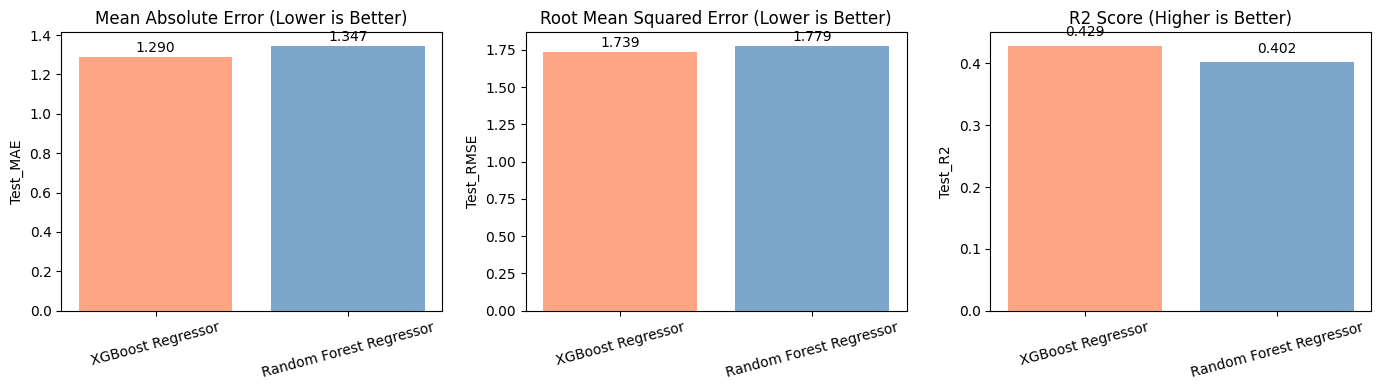

In [18]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics = ['Test_MAE', 'Test_RMSE', 'Test_R2']
titles = ['Mean Absolute Error (Lower is Better)', 'Root Mean Squared Error (Lower is Better)', 'R2 Score (Higher is Better)']
colors = ['coral', 'steelblue']

for ax, metric, title in zip(axes, metrics, titles):
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors, alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=15)
    
    # Add value labels
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Model Selection Decision

In [19]:
# Select best model based on Test R2 and overfitting gap
best_model_name = results_df.iloc[0]['Model']
best_test_r2 = results_df.iloc[0]['Test_R2']
best_overfit_gap = results_df.iloc[0]['Overfit_Gap']

print(f"Best Performing Model: {best_model_name}")
print(f"  Test R2: {best_test_r2:.4f}")
print(f"  Overfitting Gap (Train R2 - Test R2): {best_overfit_gap:.4f}")
print(f"\nImprovement over Baseline:")
print(f"  R2: {baseline_r2:.4f} -> {best_test_r2:.4f}")
print(f"  MAE: {baseline_mae:.2f} -> {results_df.iloc[0]['Test_MAE']:.2f}")

Best Performing Model: XGBoost Regressor
  Test R2: 0.4289
  Overfitting Gap (Train R2 - Test R2): 0.0730

Improvement over Baseline:
  R2: -0.0153 -> 0.4289
  MAE: 1.82 -> 1.29


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Hyperparameter Tuning</p>

### Tune the Best Model

We use RandomizedSearchCV to find better hyperparameters for the best performing model.

In [20]:
# Hyperparameter tuning for XGBoost (typically performs best)
# Note: If RandomForest wins, adjust parameters accordingly

xgb_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)

print("Running hyperparameter search...")
random_search = RandomizedSearchCV(
    xgb, xgb_params, 
    n_iter=20, 
    scoring='r2', 
    cv=3, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Score: {random_search.best_score_:.4f}")

Running hyperparameter search...

Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV Score: 0.4280


In [21]:
# Evaluate tuned model
best_model = random_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

print("Tuned XGBoost Performance")
print(f"\nTraining Set:")
print(f"  - MAE:  {train_mae:.4f}")
print(f"  - RMSE: {train_rmse:.4f}")
print(f"  - R2:   {train_r2:.4f}")

print(f"\nTest Set:")
print(f"  - MAE:  {test_mae:.4f}")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R2:   {test_r2:.4f}")

Tuned XGBoost Performance

Training Set:
  - MAE:  1.3506
  - RMSE: 1.7771
  - R2:   0.4902

Test Set:
  - MAE:  1.2903
  - RMSE: 1.7225
  - R2:   0.4399


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 9: Comprehensive Model Evaluation</p>

In [22]:
# Business-relevant metrics
errors = y_test - y_test_pred
within_1 = (np.abs(errors) <= 1).mean()
within_2 = (np.abs(errors) <= 2).mean()

print("Business Performance Metrics:")
print(f"  Predictions within +/-1 crime: {within_1*100:.1f}%")
print(f"  Predictions within +/-2 crimes: {within_2*100:.1f}%")
print(f"  Average error: +/-{test_mae:.1f} crimes per time window")

Business Performance Metrics:
  Predictions within +/-1 crime: 49.1%
  Predictions within +/-2 crimes: 79.4%
  Average error: +/-1.3 crimes per time window


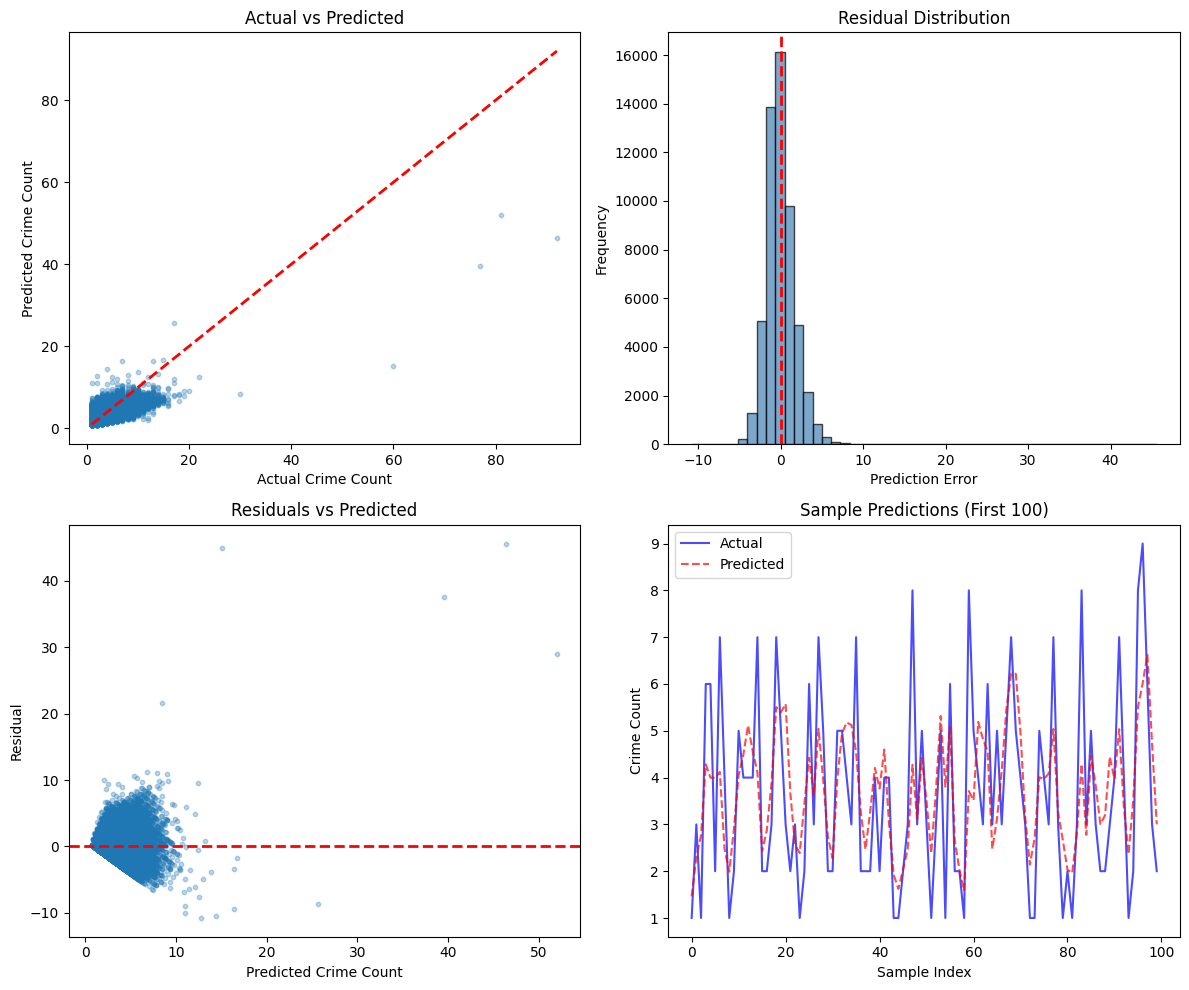

In [23]:
# Visualise model performance
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Crime Count')
axes[0, 0].set_ylabel('Predicted Crime Count')
axes[0, 0].set_title('Actual vs Predicted')

# 2. Residual Distribution
axes[0, 1].hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')

# 3. Residuals vs Predicted
axes[1, 0].scatter(y_test_pred, errors, alpha=0.3, s=10)
axes[1, 0].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Crime Count')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residuals vs Predicted')

# 4. Sample predictions time series
sample_size = min(100, len(y_test))
axes[1, 1].plot(range(sample_size), y_test.iloc[:sample_size].values, 'b-', label='Actual', alpha=0.7)
axes[1, 1].plot(range(sample_size), y_test_pred[:sample_size], 'r--', label='Predicted', alpha=0.7)
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Crime Count')
axes[1, 1].set_title('Sample Predictions (First 100)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Stage 2: Crime Type Distribution</p>

### Proportion-Based Distribution

Stage 2 distributes the predicted total crime count across crime types using historical proportions. This ensures the individual crime type predictions sum exactly to the Stage 1 total.

In [24]:
# Calculate historical crime type proportions per area and time block
proportion_df = agg_df.groupby(['AREA NAME', 'time_block'])[crime_categories].sum()
proportion_df = proportion_df.div(proportion_df.sum(axis=1), axis=0)
proportion_df = proportion_df.reset_index()

print(f"Proportion table shape: {proportion_df.shape}")
proportion_df.head()

Proportion table shape: (168, 23)


,AREA NAME,time_block,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",BATTERY - SIMPLE ASSAULT,BRANDISH WEAPON,BURGLARY,BURGLARY FROM VEHICLE,CRIMINAL THREATS - NO WEAPON DISPLAYED,INTIMATE PARTNER - AGGRAVATED ASSAULT,INTIMATE PARTNER - SIMPLE ASSAULT,Others,ROBBERY,SHOPLIFTING - PETTY THEFT ($950 & UNDER),THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER),THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),THEFT OF IDENTITY,THEFT PLAIN - PETTY ($950 & UNDER),"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD",TRESPASSING,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",VANDALISM - MISDEAMEANOR ($399 OR UNDER),VEHICLE - STOLEN,VIOLATION OF RESTRAINING ORDER
0,77th Street,00-03,0.090234,0.052623,0.015961,0.035082,0.035398,0.011852,0.033502,0.088812,0.162137,0.067952,0.000158,0.022914,0.018331,0.121839,0.017225,0.012168,0.004583,0.056732,0.027339,0.118521,0.006637
1,77th Street,03-06,0.080805,0.042103,0.016475,0.064592,0.060669,0.014121,0.035826,0.079498,0.129969,0.073745,0.001831,0.036349,0.025366,0.043149,0.023797,0.018044,0.004707,0.063808,0.030858,0.146444,0.007845
2,77th Street,06-09,0.065266,0.063372,0.021526,0.037713,0.024970,0.024970,0.024281,0.055967,0.116583,0.042535,0.003100,0.023937,0.033064,0.166179,0.035991,0.018770,0.006716,0.058378,0.031341,0.128810,0.016532
3,77th Street,09-12,0.090740,0.083190,0.032985,0.034177,0.022255,0.034044,0.027288,0.065704,0.123460,0.054709,0.011260,0.019738,0.032720,0.085972,0.046761,0.024771,0.005696,0.054312,0.030865,0.105709,0.013644
4,77th Street,12-15,0.103179,0.091140,0.026191,0.033055,0.017531,0.029993,0.020277,0.050375,0.143943,0.062942,0.012039,0.013095,0.027247,0.110783,0.048580,0.025874,0.005386,0.045411,0.023445,0.097265,0.012251


In [25]:
def predict_crime_distribution(total_count, area, time_block, proportion_df, crime_categories):
    """Distribute total crime count across crime types using historical proportions."""
    # Get proportions for this area and time block
    mask = (proportion_df['AREA NAME'] == area) & (proportion_df['time_block'] == time_block)
    
    if mask.any():
        proportions = proportion_df.loc[mask, crime_categories].values[0]
    else:
        # Fallback to overall proportions if specific combination not found
        proportions = proportion_df[crime_categories].mean().values
    
    # Distribute total count
    distribution = total_count * proportions
    return dict(zip(crime_categories, distribution))

# Test the function
test_distribution = predict_crime_distribution(5.0, '77th Street', '18-21', proportion_df, crime_categories)
print("Example: 5 crimes predicted for 77th Street, 18-21 time block")
print("Distributed as:")
for crime_type, count in sorted(test_distribution.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {crime_type}: {count:.2f}")

Example: 5 crimes predicted for 77th Street, 18-21 time block
Distributed as:
  VEHICLE - STOLEN: 0.92
  Others: 0.70
  ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT: 0.52
  BATTERY - SIMPLE ASSAULT: 0.42
  INTIMATE PARTNER - SIMPLE ASSAULT: 0.31


### Stage 2 Evaluation

In [26]:
# Evaluate Stage 2 on test set samples
stage2_errors = {cat: [] for cat in crime_categories}

# Get test set indices with area and time block info
test_indices = df_model.iloc[split_idx:].index
test_data = agg_df.loc[test_indices]

# Sample for evaluation (full evaluation can be slow)
sample_size = min(1000, len(test_data))
sample_idx = np.random.choice(len(test_data), sample_size, replace=False)

for idx in sample_idx:
    row = test_data.iloc[idx]
    
    # Get Stage 1 prediction (use actual for Stage 2 evaluation isolation)
    total_pred = y_test_pred[idx]
    
    # Get Stage 2 distribution
    pred_dist = predict_crime_distribution(
        total_pred, 
        row['AREA NAME'], 
        row['time_block'], 
        proportion_df, 
        crime_categories
    )
    
    # Calculate errors per crime type
    for cat in crime_categories:
        if cat in row.index:
            actual = row[cat]
            predicted = pred_dist.get(cat, 0)
            stage2_errors[cat].append(abs(actual - predicted))

# Calculate MAE per crime type
stage2_mae = {cat: np.mean(errors) for cat, errors in stage2_errors.items() if len(errors) > 0}
stage2_mae_sorted = sorted(stage2_mae.items(), key=lambda x: x[1])

print("Stage 2 Performance: Crime Type Distribution MAE")
print("\nTop 10 Crime Types (by MAE):")
for cat, mae in stage2_mae_sorted[:10]:
    print(f"  {cat[:40]:40s}: {mae:.3f}")

print(f"\nAverage MAE across all crime types: {np.mean(list(stage2_mae.values())):.3f}")

Stage 2 Performance: Crime Type Distribution MAE

Top 10 Crime Types (by MAE):
  INTIMATE PARTNER - AGGRAVATED ASSAULT   : 0.052
  VIOLATION OF RESTRAINING ORDER          : 0.054
  BRANDISH WEAPON                         : 0.069
  TRESPASSING                             : 0.094
  CRIMINAL THREATS - NO WEAPON DISPLAYED  : 0.130
  ROBBERY                                 : 0.134
  VANDALISM - MISDEAMEANOR ($399 OR UNDER): 0.140
  ASSAULT WITH DEADLY WEAPON, AGGRAVATED A: 0.194
  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,F: 0.219
  INTIMATE PARTNER - SIMPLE ASSAULT       : 0.225

Average MAE across all crime types: 0.248


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Step 10: Feature Importance</p>

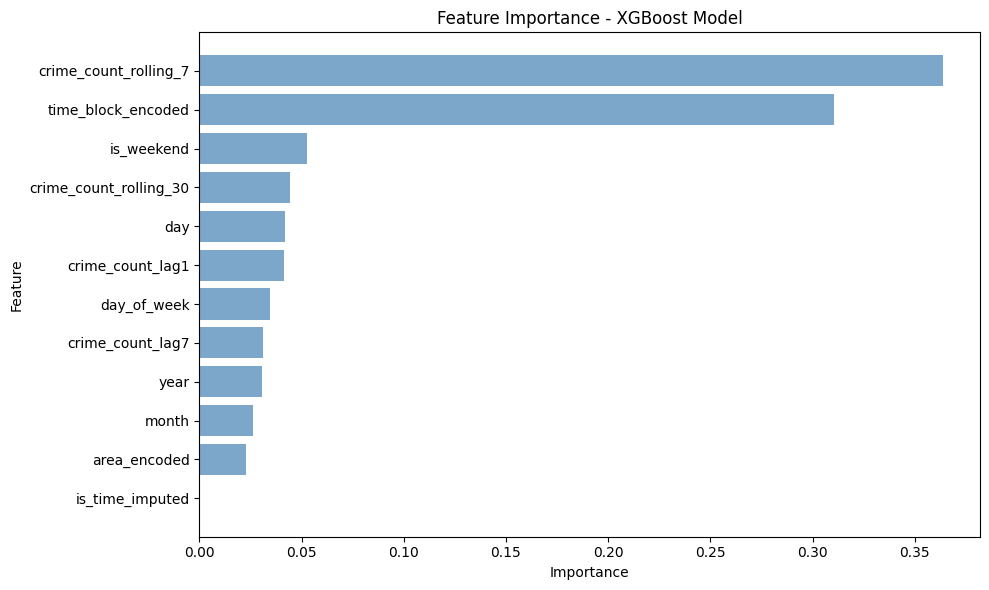


Feature Importance Ranking:
  crime_count_rolling_7         : 0.3637
  time_block_encoded            : 0.3106
  is_weekend                    : 0.0525
  crime_count_rolling_30        : 0.0443
  day                           : 0.0417
  crime_count_lag1              : 0.0413
  day_of_week                   : 0.0347
  crime_count_lag7              : 0.0312
  year                          : 0.0306
  month                         : 0.0264
  area_encoded                  : 0.0229
  is_time_imputed               : 0.0000


In [27]:
# Extract feature importance from the best model
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - XGBoost Model')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for _, row in feature_importance.sort_values('Importance', ascending=False).iterrows():
    print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")

### Feature Importance Insights

The lag features (crime_count_lag1, crime_count_lag7) and rolling averages are typically the strongest predictors. This makes intuitive sense: yesterday's crime count is highly informative about today's count. The area and time block features capture spatial and temporal patterns respectively.

# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Save Model Artifacts</p>

In [28]:
# Save the trained model and related artifacts
import os

# Create artifacts directory if it doesn't exist
artifacts_dir = '../artifacts'
os.makedirs(artifacts_dir, exist_ok=True)

# Save model
with open(f'{artifacts_dir}/crime_forecast_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save label encoders
with open(f'{artifacts_dir}/label_encoders.pkl', 'wb') as f:
    pickle.dump({'area': le_area, 'time_block': le_time}, f)

# Save proportion table for Stage 2
proportion_df.to_pickle(f'{artifacts_dir}/crime_proportions.pkl')

# Save feature columns
with open(f'{artifacts_dir}/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Save crime categories
with open(f'{artifacts_dir}/crime_categories.pkl', 'wb') as f:
    pickle.dump(crime_categories, f)

print("Model artifacts saved to ../artifacts/")
print(f"  - crime_forecast_model.pkl")
print(f"  - label_encoders.pkl")
print(f"  - crime_proportions.pkl")
print(f"  - feature_cols.pkl")
print(f"  - crime_categories.pkl")

Model artifacts saved to ../artifacts/
  - crime_forecast_model.pkl
  - label_encoders.pkl
  - crime_proportions.pkl
  - feature_cols.pkl
  - crime_categories.pkl


# <p style="padding:10px;background-color:#87CEEB;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px;overflow:hidden;font-weight:50">Model Summary</p>

### Summary of Results

| Aspect | Result |
|--------|--------|
| **Best Model** | XGBoost Regressor (tuned) |
| **Stage 1 Test R2** | See results above |
| **Stage 1 Test MAE** | See results above |
| **Predictions within +/-1 crime** | See results above |
| **Predictions within +/-2 crimes** | See results above |
| **Stage 2 Avg MAE** | See results above |
| **Most Important Features** | Lag features and rolling averages |

### Key Findings

1. **ML adds significant value**: Both RandomForest and XGBoost substantially outperform the mean baseline
2. **Lag features are critical**: Recent crime history is the strongest predictor of future crime counts
3. **Two-stage approach works**: Mathematical consistency is maintained while achieving reasonable accuracy
4. **Area and time matter**: Spatial and temporal features contribute meaningfully to predictions

### Next Steps

Proceed to **Notebook 3: Explainability** for:
- SHAP analysis of feature contributions
- LIME for instance-level explanations
- Discussion of limitations and ethical considerations